In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

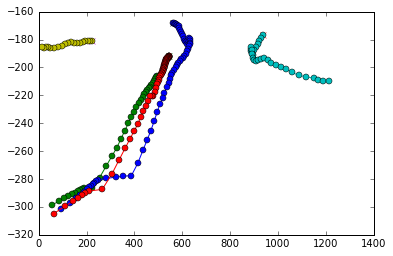

In [33]:
for i in np.random.choice(len(tracks.items()), 5):
    track = np.array(tracks.items()[i][1])
    plt.plot(track[0,0], -track[0,1], marker="x")
    plt.plot(track[:,0], -track[:,1], marker="o")

In [34]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [36]:
np.random.seed(7)

In [58]:
def buildDataset(tracks):
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < len(track)-1:
                dataset.append((tuple(pos + track[i+1])))
    return dataset
                
dataset = buildDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [62]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(17903, 8818)


In [73]:
xtrain = np.matrix(train[:,0:2])
ytrain = np.matrix(train[:,2:])
xtest = np.matrix(test[:,0:2])
ytest = np.matrix(test[:,2:])

In [101]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 1, xtest.shape[1]))

In [98]:
xsample = xtrain[0, :]
ysample = ytrain[0,:]
print xsample
print ysample

[[ 0.62446123  0.10217015]]
[[ 0.62740964  0.09628095]]


In [99]:
xsample = np.array(xsample).reshape((1,1,2))


In [103]:
model = Sequential()
model.add(LSTM(4, input_dim=2))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)

Epoch 1/10
20s - loss: 0.0046
Epoch 2/10
20s - loss: 2.2554e-04
Epoch 3/10
21s - loss: 2.0010e-04
Epoch 4/10
21s - loss: 1.9204e-04
Epoch 5/10
22s - loss: 1.8807e-04
Epoch 6/10
30s - loss: 1.8630e-04
Epoch 7/10
25s - loss: 1.8546e-04
Epoch 8/10
27s - loss: 1.8350e-04
Epoch 9/10
28s - loss: 1.8332e-04
Epoch 10/10
26s - loss: 1.8250e-04


In [116]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0139828 RMSE
Test Score: 0.0135981 RMSE


In [122]:
def rebuildTracks(xtrain, ytrain, xtest, ytest, trainPredict, testPredict, tracks):
    rawdata = []
    predictions = []
    trainindex = 0
    testindex = 0
    for track in tracks.items():
        sample = []
        prediction = []
        for i, pos in enumerate(track):
            if trainindex >= len(xtrain)-1:
                x = xtrain
                y = ytrain
                pred = trainPredict
                index = trainindex
            else:
                x = xtest
                y = ytest
                pred = testPredict
                index = testindex
            if i == 1:
                prediction.append(x[index])
                prediction.append(pred[index])
            if i == len(track)-1:
                sample.append(x[index])
                sample.append(y[index])
            else:
                sample.append(x[index])
                prediction.append(pred[index])
            if trainindex >= len(xtrain)-1:
                trainindex += 1
            else:
                testindex += 1
        rawdata.append(sample)
        predictions.append(prediction)
    return rawdata, predictions

In [123]:
rawdata, predictions = rebuildTracks(xtrain, ytrain, xtest, ytest, trainPredict, testPredict, tracks)

TypeError: 'NoneType' object is not iterable

In [124]:
rawdata = []
predictions = []
trainindex = 0
testindex = 0
for track in tracks.items():
    sample = []
    prediction = []
    for i, pos in enumerate(track):
        if trainindex >= len(xtrain)-1:
            x = xtrain
            y = ytrain
            pred = trainPredict
            index = trainindex
        else:
            x = xtest
            y = ytest
            pred = testPredict
            index = testindex
        if i == 1:
            prediction.append(x[index])
            prediction.append(pred[index])
        if i == len(track)-1:
            sample.append(x[index])
            sample.append(y[index])
        else:
            sample.append(x[index])
            prediction.append(pred[index])
        if trainindex >= len(xtrain)-1:
            trainindex += 1
        else:
            testindex += 1
    rawdata.append(sample)
    predictions.append(prediction)

In [131]:
len(rawdata[2])

3